In [438]:
import pandas as pd
import seaborn as sns
from mpmath import *
from sympy import *

import numpy as np
from numpy import linalg as LA
from random import randint, uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [439]:
from attacks import *
from defenses import *

In [440]:
from benchmark_helper import show_adversarial_sample
from benchmark_helper import benchmark_attack_by_model
from benchmark_helper import benchmark_defense_by_model
from benchmark_helper import benchmark_attack_models_visual
from benchmark_helper import benchmark_defense_models_visual
from benchmark_helper import get_adv_by_model_norm
from benchmark_helper import compare_model_for_two_inputs

In [441]:
normalization = 255
width = 28
heigth = 28

In [442]:
def normalize(X):
    return X / normalization

In [443]:
def denormalize(X):
    return X * normalization

In [444]:
def to_image_shape(X):
    return np.array(X).reshape(-1, width, heigth)

In [445]:
def to_vector_shape(X):
    return np.array(X).reshape(-1, width * heigth)

In [446]:
filename_test = "./data/digit-recognizer/test.csv"
filename_train = "./data/digit-recognizer/train.csv"

df_train = pd.read_csv(filename_train, delimiter=',')
df_test = pd.read_csv(filename_test, delimiter=',')

X = df_train.loc[:, df_train.columns != "label"]
y = df_train.loc[:, df_train.columns == "label"]
X = X.to_numpy()
y = y.to_numpy()
print('Dataset: X={}, y={}'.format(X.shape, y.shape))

Dataset: X=(42000, 784), y=(42000, 1)


In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600, 1)
Test set: X=(8400, 784), y=(8400, 1)


In [448]:
X_test_images = to_image_shape(X_test)

#### Show images

In [449]:
# X_show = X_train.to_numpy().reshape(-1,28,28)
# show_samples(X_show, nrows=8, ncols=8, rsize=10, csize=10)

#### One Hot Encoding

In [450]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(y_train)

Y_train = encoder.transform(y_train).toarray()
y_labels = [x[3:] for x in  encoder.get_feature_names()]

encoder.fit(y_test)
Y_test = encoder.transform(y_test).toarray()

In [451]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

def custom_scorer(estimator, X, Y):
    # transform from one hot encoding to label encoding 
    y_true = np.argmax(Y, axis=1)
    y_pred = estimator.predict(X)
    return accuracy_score(y_true, y_pred)

#### Hyperparameters selection

In [452]:
# from sklearn.model_selection import GridSearchCV
# #from LogisticRegression import CustomLogisticRegression

# model_params = dict(
#                 normalize=[False],
#                 learning_rate=[0.1, 0.01], 
#                 num_iters=[100, 300, 500],
#                 batch_size=[64, 128, 1024, -1],
#                 momentum=[0, 0.5, 0.9]
# )
# model = CustomLogisticRegression()
# grid = GridSearchCV(estimator=model, param_grid=model_params, scoring=custom_scorer, cv=2, n_jobs=-1)

In [453]:
# %%time
# grid.fit(normalize(X_train), Y_train)
#{'learning_rate': 0.1, 'num_iters': 200, 'batch_size': 128, 'momentum': 0.5, 'normalize': False}

In [454]:
# res = [print(f"{key}: {val}") for key, val in grid.best_params_.items()]

#### Model Training

In [455]:
from logistic_regression import CustomLogisticRegression

{'learning_rate': 1, 'num_iters': 200, 'batch_size': 1024, 'momentum': 0, 'normalize': False}
0 iteration: 0.5068035658253782
100 iteration: 0.19921868911144733


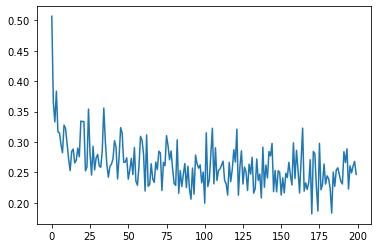

In [456]:
model_params = dict(
                normalize=False,
                learning_rate=1, 
                num_iters=200,
                batch_size=1024,
                momentum=0
)

lg = CustomLogisticRegression()
lg.set_params(**model_params)
lg.fit(normalize(X_train), Y_train)
plt.plot(lg.get_cost_history())


#### Prediction

In [457]:
y_pred = lg.predict(normalize(X_test))
accuracy_score(y_pred, y_test)

0.9208333333333333

#### Benchmark

In [458]:
# %%time
# defense_random = Randomization(resize_range=(-3, 3), pad_range=(0, 0))
# X_test_randomized = to_vector_shape(defense_random.get_defended(X_test_images))
# y_pred_randomized = lg.predict(normalize(X_test_randomized))
# accuracy_score(y_test, y_pred_randomized)

In [738]:
from defenses import PixelDeflection

def find_best_deflect_params(X, Y_test, y_test, model=None, max_deflections=15, max_window=15, samples=100):
    min_result = 0
    d_ = 0
    w_ = 0
    count = 0
    
    for d in np.array(range(1, max_deflections)):
        for w in np.array(range(2, max_window)):
            defense_deflection = PixelDeflection(deflections=d, window=w)
            X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images[0:samples], rcam_prob=res.reshape(28, 28)))
            y_pred_deflected = model.predict(normalize(X_test_deflected))

            X1_res, X2_res = compare_model_for_two_inputs(
                X_test, X_test_deflected, Y_test, y_test, model=model, attack=AttackFGSM, samples=samples, num_steps=10, visualize=False
            )
            if count == 0:
                min_result = X1_res

            if (X2_res < min_result):
                d_ = d
                w_ = w
                min_result = X2_res
            count += 1

    print(d_, w_)
    return d_, w_

d, w = find_best_deflect_params(X, Y_test, y_test, model=lg, max_window=15, max_deflections=15, samples=100)

9 8


In [ ]:
defense_deflection = PixelDeflection(deflections=d, window=w)
X_test_deflected = to_vector_shape(defense_deflection.get_defended(X_test_images, rcam_prob=res.reshape(28, 28)))
compare_model_for_two_inputs(X_test, X_test_deflected, Y_test, y_test, model=lg, attack=AttackFGSM, samples=1000, num_steps=10, visualize=True)

0.762


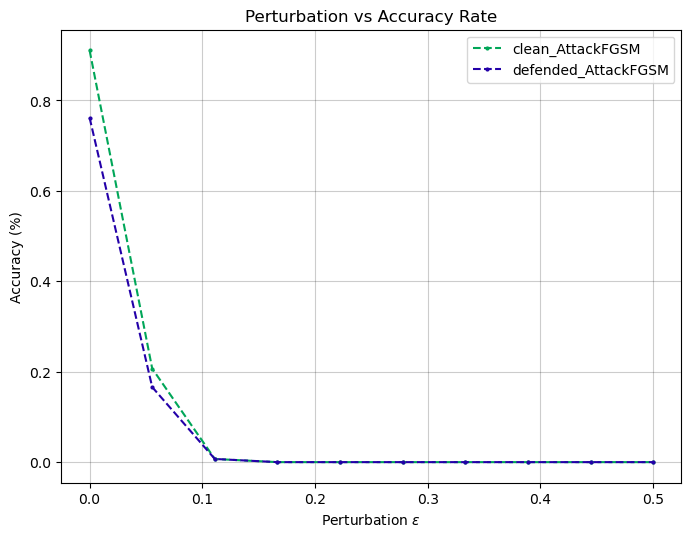

In [537]:
defense_rand = Randomization(resize_window=3, pad_window=0)
X_test_rand = to_vector_shape(defense_rand.get_defended(X_test_images[0:1000]))
print(accuracy_score(lg.predict(normalize(X_test_rand)), y_test[0:1000]))
a, b = compare_model_for_two_inputs(X_test, X_test_rand, Y_test, y_test, model=lg, attack=AttackFGSM, samples=1000, num_steps=10)

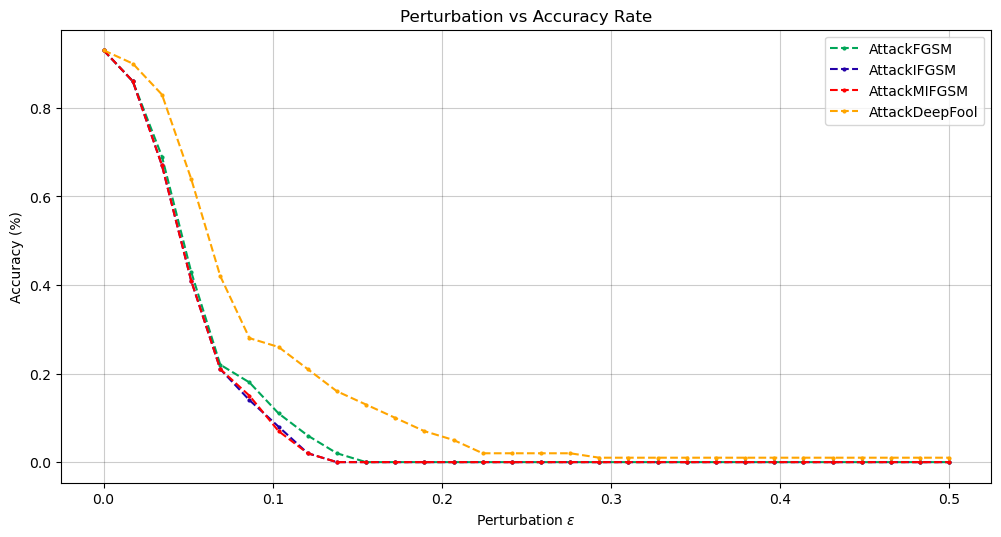

In [116]:
benchmark_defense_models_visual(X_test, Y_test, y_test, model=lg, samples=100, num_steps=30)

In [117]:
def benchmark_attack_models_visual(X, y_labels, model=None, samples=100, num_steps=10):
    x1, y1, label1 = benchmark_attack_by_model(X, y_labels, model=model, attack_model=AttackFGSM, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_attack_by_model(X, y_labels, model=model, attack_model=AttackIFGSM, samples=samples, num_steps=num_steps)
    x3, y3, label3 = benchmark_attack_by_model(X, y_labels, model=model, attack_model=AttackMIFGSM, samples=samples, num_steps=num_steps)
    x4, y4, label4 = benchmark_attack_by_model(
        X, y_labels, model=model, attack_model=AttackDeepFool, samples=samples, num_steps=num_steps
    )

    fig, ax = plt.subplots(num=None, figsize=(12, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Perturbation vs Accuracy Rate')
    ax.set_xlabel(r"Perturbation $\epsilon$")
    ax.set_ylabel('Accuracy (%)')

    plt.plot(np.array(x1), y1, linestyle='--', marker='o', markersize=2, color='#00A658', label = label1)
    plt.plot(np.array(x2), y2, linestyle='--', marker='o', markersize=2, color='#2300A8', label = label2)
    plt.plot(np.array(x3), y3, linestyle='--', marker='o', markersize=2, color='red', label = label3)
    plt.plot(np.array(x4), y4, linestyle='--', marker='o', markersize=2, color='orange', label = label4)

    plt.legend()


In [118]:
benchmark_attack_models_visual(X_test, y_labels, model=lg, samples=100, num_steps=10)

TypeError: benchmark_attack_by_model() got an unexpected keyword argument 'attack_model'

In [ ]:
def get_rmap(X, Y_true, y_true, model=None, attack=None, samples=100):
    X_normalize = normalize(X[0:samples])
    y_true = y_true[0:samples].reshape(samples)

    X_adv = get_adv_by_model_norm(X_normalize, Y_true, model=model, attack=attack, norm=0.5)
    return np.sum(X_normalize[0:samples] - X_adv, axis=0)

img = get_rmap(X_test, Y_test, y_test, model=lg, attack=AttackDeepFool, samples=100)

img = (img-np.min(img, axis=0))/(np.max(img, axis=0)-np.min(img, axis=0))
plt.imshow(img.reshape(28, 28))
sns.heatmap(img.reshape(28, 28))

#### RMAP

In [ ]:
# X_test.iloc[0, :].shape

# avg = 0
# for i in range(X_test.shape[0]):
#     attack = AttackFGSM()
#     x_ = normalize(np.expand_dims(X_test.iloc[i, :], axis=0))
#     a = attack.attack(x_, lg.W, lg.b, y, lg.predict, max_norm=1)
#     avg = avg + (x_ - a)
    

In [ ]:
# #avg = avg / X_test.shape[0]
# #plt.imshow(avg.reshape(28, 28))
# #avg
# denormalize(avg) / X_test.shape[0]
# rmap = abs((avg / X_test.shape[0]).reshape(28, 28))
# plt.imshow(rmap, 'gray')
# rmap[15]

In [ ]:
# x_ = X_test.to_numpy().reshape(-1, 28,28)[0]
# res = pixel_deflection_with_map(x_, avg.reshape(-28, 28), 100, 20)
# plt.imshow(res)

In [ ]:
# avg = avg / X_test.shape[0]
# plt.imshow(avg.reshape(28, 28))

In [215]:
correct_pred_idx = lg.predict(normalize(X_test)) == y_test[:, 0]

#### Untargeted Noise Attack

In [217]:
# index = 38
# x = np.expand_dims(X_test[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackNoise, max_norm=1)

#### Untargeted FGSM

In [219]:
# index = 0
# x = np.expand_dims(X_test[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackFGSM, max_norm=0.2)

#### Untargeted I-FGSM

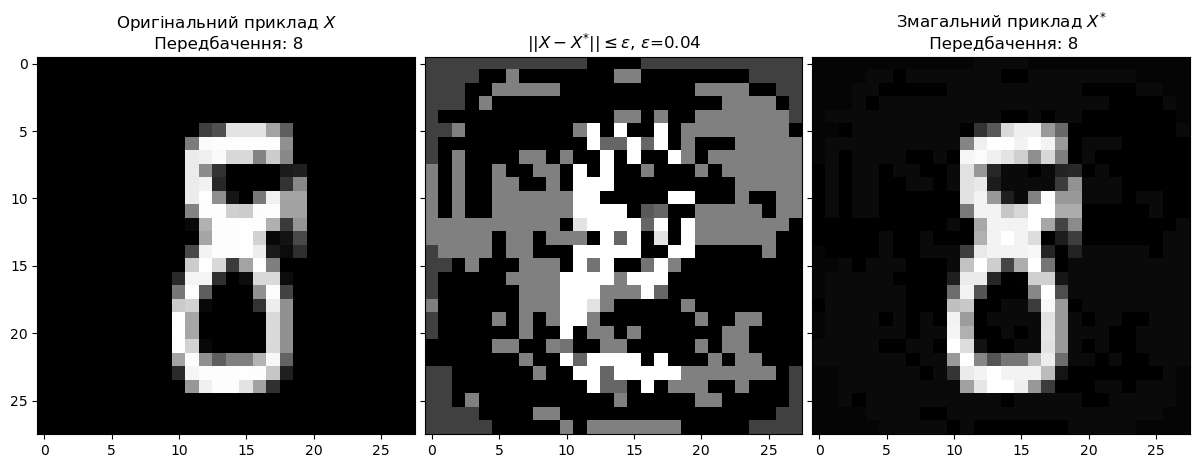

In [339]:
index = 1
x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=0.04, max_iters=100)

#### DeepFool

In [342]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=0.15, max_iters=12)

#### Targeted I-FGSM

In [ ]:
# index = 1
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))
# y[9] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackTIFGSM, max_norm=0.2, max_iters=5000)

#### Untargeted MI-FGSM

In [ ]:
# index = 123
# x = np.expand_dims(X_test[correct_pred_idx].iloc[index, :], axis=0)
# y = np.zeros(len(y_labels))

# true_class = lg.predict(normalize(x))
# y[true_class] = 1

# show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackMIFGSM, max_norm=1, max_iters=5000)

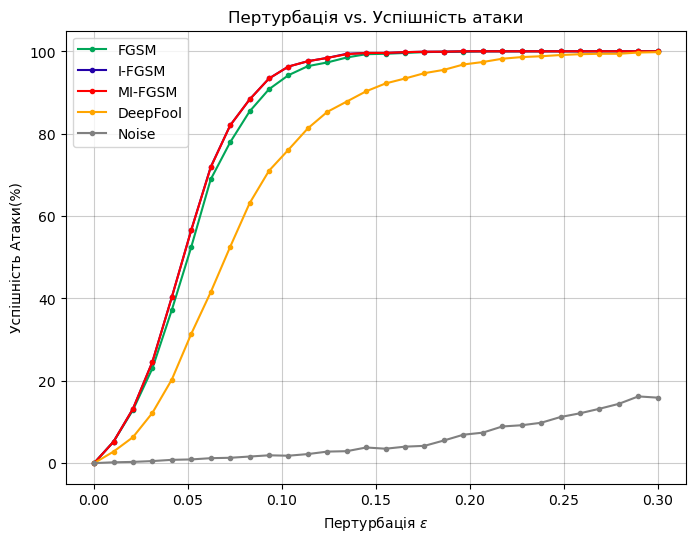

In [205]:
def benchmark_attack_by_model(X, y_labels, model=None, attack=None, samples=100, num_steps=15):
    X_norm = normalize(X)
    iter_res_dict = {}

    norms_range = np.linspace(0, 0.3, num=num_steps)

    for i in range(samples):
        x_normalized = np.expand_dims(X_norm[i, :], axis=0)
        y = np.zeros(len(y_labels))
        true_class_pos = model.predict(x_normalized)
        y[true_class_pos] = 1
    
        for norm in norms_range:
            atck = attack()
            if type(atck).__name__ in ['AttackNoise']:
                atck.attack(x_normalized, y, model.predict, max_norm=norm)
            elif type(atck).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackDeepFool', 'AttackFGSM']:
                atck.attack(x_normalized, model.W, model.b, y, model.predict, max_norm=norm)
            
            elif type(atck).__name__ in ['AttackMIFGSM']:
                atck.attack(x_normalized, model.W, model.b, y, model.predict, max_norm=norm, momentum=0.89)
        
            success = atck.tricked
            
            if norm in iter_res_dict.keys():
                iter_res_dict[norm]["appearance_count"] += 1
                iter_res_dict[norm]["success_count"] += success
            else:
                iter_res_dict.update({norm: {"appearance_count": 1, "success_count": success} })

    success_rate = {}
    for key, value in iter_res_dict.items():
        success_rate[key] = value["success_count"] / value["appearance_count"] * 100

    perturbations_list = [x[0] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]
    successrate_list = [x[1] for x in sorted(success_rate.items(), key=lambda x: x[0]) ]

    return perturbations_list, successrate_list, type(atck).__name__


def benchmark_attack_models_visual(X, y_true, y_labels, model=None, samples=100, num_steps=10):    
    y_correct_idx = (model.predict(normalize(X)) == y_true[:, 0])
    x1, y1, label1 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackFGSM, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackIFGSM, samples=samples, num_steps=num_steps)
    x3, y3, label3 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackMIFGSM, samples=samples, num_steps=num_steps)
    x4, y4, label4 = benchmark_attack_by_model(
        X[y_correct_idx], y_labels, model=model, attack=AttackDeepFool, samples=samples, num_steps=num_steps
    )
    x5, y5, label5 = benchmark_attack_by_model(X[y_correct_idx], y_labels, model=model, attack=AttackNoise, samples=samples, num_steps=num_steps)

    fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Пертурбація vs. Успішність атаки')
    ax.set_xlabel(r"Пертурбація $\epsilon$")
    ax.set_ylabel('Успішність Атаки(%)')

    plt.plot(np.array(x1), y1, linestyle='-', marker='o', markersize=3, color='#00A658', label = "FGSM")
    plt.plot(np.array(x2), y2, linestyle='-', marker='o', markersize=3, color='#2300A8', label = "I-FGSM")
    plt.plot(np.array(x3), y3, linestyle='-', marker='o', markersize=3, color='red', label = "MI-FGSM")
    plt.plot(np.array(x4), y4, linestyle='-', marker='o', markersize=3, color='orange', label = "DeepFool")
    plt.plot(np.array(x5), y5, linestyle='-', marker='o', markersize=3, color='gray', label = "Noise")
    
    plt.legend()
    
benchmark_attack_models_visual(X_test, y_test, y_labels, model=lg, samples=1000, num_steps=30)

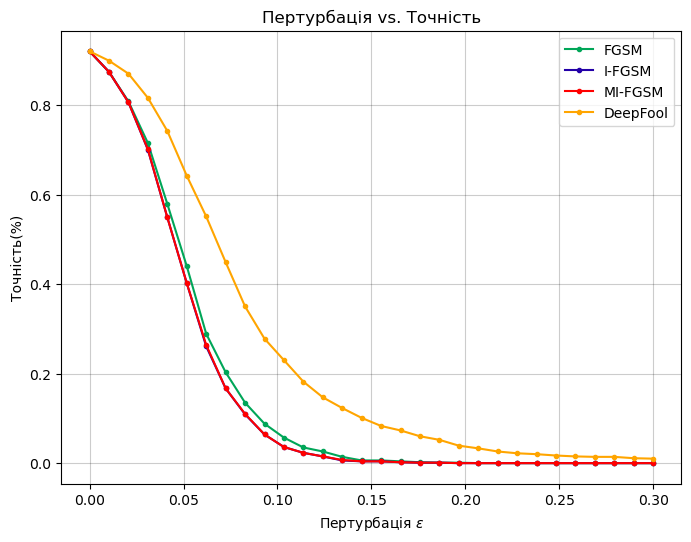

In [202]:
def benchmark_defense_by_model(X, Y_true, y_true, model=None, attack=None, samples=100, num_steps=0, a=0, b=0.3):
    norms = np.linspace(a, b, num=num_steps)
    scores = np.zeros(norms.shape)

    for idx, norm in enumerate(norms):
        X_normalize = normalize(X[0:samples])
        y_true = y_true[0:samples].reshape(samples)

        X_adv = get_adv_by_model_norm(X_normalize, Y_true, model=model, attack=attack, norm=norm)
        scores[idx] = accuracy_score(model.predict(X_adv), y_true)
    return norms, scores, attack.__name__


def benchmark_defense_models_visual(X, Y_true, y_true, model=None, samples=100, num_steps=10):
    x1, y1, label1 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackFGSM, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackIFGSM, samples=samples, num_steps=num_steps)
    x3, y3, label3 = benchmark_defense_by_model(X, Y_true, y_true, model=model, attack=AttackMIFGSM, samples=samples, num_steps=num_steps)
    x4, y4, label4 = benchmark_defense_by_model(
        X, Y_true, y_true, model=model, attack=AttackDeepFool, samples=samples, num_steps=num_steps
    )


    fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w')
    plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
    ax.set_title('Пертурбація vs. Точність')
    ax.set_xlabel(r"Пертурбація $\epsilon$")
    ax.set_ylabel('Точність(%)')

    plt.plot(np.array(x1), y1, linestyle='-', marker='o', markersize=3, color='#00A658', label = "FGSM")
    plt.plot(np.array(x2), y2, linestyle='-', marker='o', markersize=3, color='#2300A8', label = "I-FGSM")
    plt.plot(np.array(x3), y3, linestyle='-', marker='o', markersize=3, color='red', label = "MI-FGSM")
    plt.plot(np.array(x4), y4, linestyle='-', marker='o', markersize=3, color='orange', label = "DeepFool")
    plt.legend()
    
benchmark_defense_models_visual(X_test, Y_test, y_test, model=lg, samples=1000, num_steps=30)

In [429]:
def show_adversarial_sample(x, y_labels, true_class=[], model=None, attack_model=None, max_norm=10, max_iters=10):

    x_normalized = normalize(x)
    attack = attack_model()

    if type(attack).__name__ in ['AttackNoise']:
        x_adv_normalized = attack.attack(x_normalized, true_class, model.predict, max_norm=max_norm)
    
    elif type(attack).__name__ in ['AttackIFGSM', 'AttackTIFGSM', 'AttackFGSM', 'AttackDeepFool', 'AttackMIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, model.W, model.b, true_class, model.predict, max_norm=max_norm)
    
    elif type(attack).__name__ in ['AttackMIFGSM']:
        x_adv_normalized = attack.attack(x_normalized, model.W, model.b, true_class, model.predict, max_norm=max_norm, momentum=0.1)
        
    x_adv = denormalize(x_adv_normalized)
    x_adv_pred = model.predict(np.array(x_adv_normalized))
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(30, 30), nrows=1, ncols=3, sharex='col', sharey='row', 
                           gridspec_kw={'hspace': 0, 'wspace': 0}, dpi=100, facecolor='w')
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, squeeze=True, sharex=True, sharey=True)
    fig.set_size_inches(15,5)
#     fig.suptitle('Змагальний приклад')
    
    ax1.imshow(x.reshape(28,28), 'gray')
    ax1.set_title(r"Оригінальний приклад "+
                  r"$X$"+
                  "\n Передбачення: "+
                  f"{model.predict(x_normalized)[0]}")
    
    ax2.imshow(x.reshape(28,28) - x_adv.reshape(28,28), "gray")
    ax2.set_title(r"$\|\|X - X^{*}\|\| \leq \varepsilon$, $\varepsilon$=" + f"{max_norm}")
    
    ax3.imshow(x_adv.reshape(28,28), 'gray')
    ax3.set_title("Змагальний приклад "+
                  r"$X^{*}$"+
                  "\n Передбачення: "+
                  f"{x_adv_pred[0]}")
    plt.show()
    pred_with_labels = model.predict_by_labels(np.array(x_adv_normalized), y_labels)
    #plt.bar(pred_with_labels[0].keys(), pred_with_labels[0].values())
    #plt.show()

    print(f"Norm_inf: {LA.norm(abs(x_normalized - x_adv_normalized), np.inf)}; Result: {attack.tricked}")
    print(f"Max value: {max(max(x_adv))}")
    print(f"Min value: {min(min(x_adv))}")

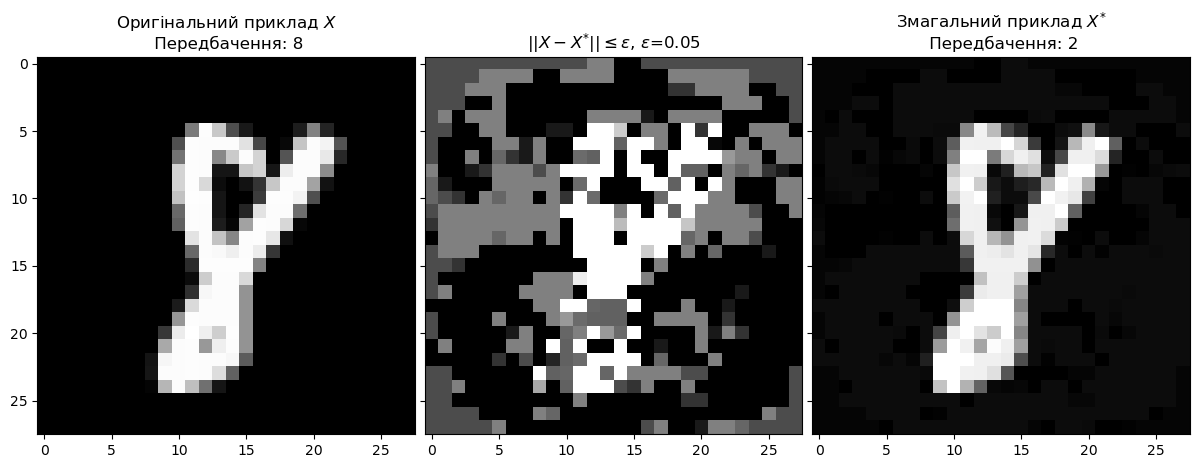

Norm_inf: 25.95352941176471; Result: True
Max value: 255.0
Min value: 0.0


In [437]:
index = 10
x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackIFGSM, max_norm=0.05, max_iters=100)

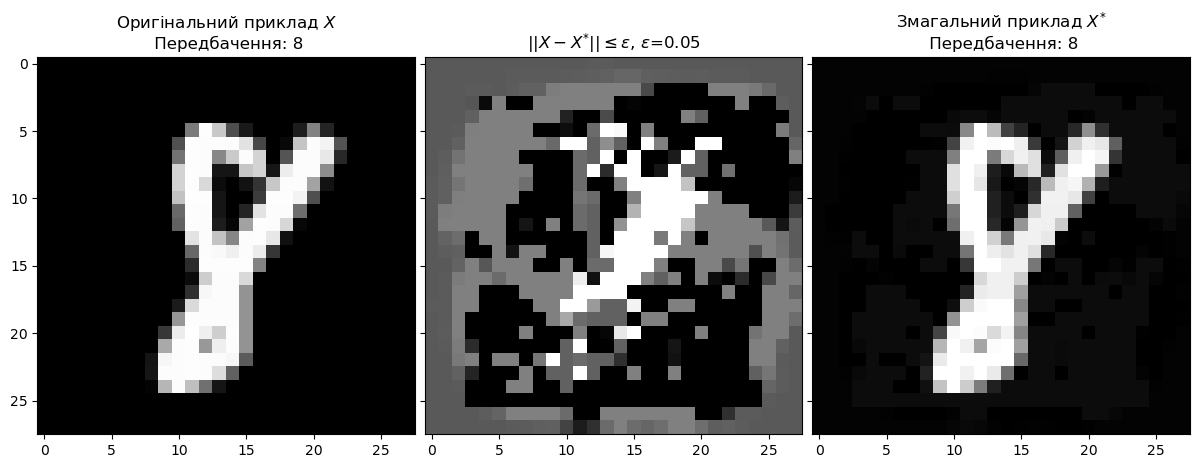

Norm_inf: 20.643059336300023; Result: False
Max value: 255.0
Min value: 0.0


In [436]:
index = 10
x = np.expand_dims(X_test[correct_pred_idx][index, :], axis=0)
y = np.zeros(len(y_labels))

true_class = lg.predict(normalize(x))
y[true_class] = 1

show_adversarial_sample(x, y_labels, true_class=y, model=lg, attack_model=AttackDeepFool, max_norm=0.05, max_iters=100)

In [514]:
def compare_model_for_two_inputs(X1, X2, Y_true, y_true, model=None, attack=None, samples=100, num_steps=10, visualize=True):
    x1, y1, label1 = benchmark_defense_by_model(X1, Y_true, y_true, model=model, attack=attack, samples=samples, num_steps=num_steps)
    x2, y2, label2 = benchmark_defense_by_model(X2, Y_true, y_true, model=model, attack=attack, samples=samples, num_steps=num_steps)
    
    if visualize:
        fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w')
        plt.grid(which='major', linestyle='-', color='black', alpha=0.2)
        ax.set_title('Perturbation vs Accuracy Rate')
        ax.set_xlabel(r"Perturbation $\epsilon$")
        ax.set_ylabel('Accuracy (%)')

        plt.plot(x1, y1, linestyle='--', marker='o', markersize=2, color='#00A658', label = f"clean_{label1}")
        plt.plot(x2, y2, linestyle='--', marker='o', markersize=2, color='#2300A8', label = f"defended_{label2}")
        plt.legend()
        
    a = round(sum(y1/num_steps), 4)
    b = round(sum(y2/num_steps), 4)
    return a,b

In [563]:
X_adv = get_adv_by_model_norm(normalize(X_test), Y_test, model=lg, attack=AttackFGSM, norm=0.1)


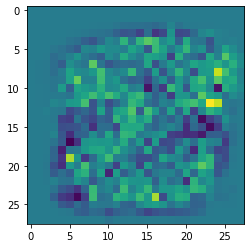

In [729]:
# print(lg.W[:, 1].shape)
# print(X_test[np.where(y_test[:, 0] == 1)].shape)
# #X_test[.shape
# X_ = X_test[np.where(y_test[:, 0] == 1)].T
#a = lg.W[:, 1]@X_
# a.shape
# #plt.imshow(a.reshape(28, 28))
# #a
res = 0
for i in range(0, 9):
    x_ = np.array([x[str(i)] for x in lg.predict_by_labels(normalize(X_test), y_labels)]).reshape(-1, 1)
    w_ = lg.W[:,i].reshape(-1, 1)
    a = np.mean(np.dot(w_, x_.T), axis=1)
    plt.imshow(a.reshape(28, 28))
    a = (a - np.min(a)) / (np.max(a) - np.min(a))
    res += a

res = res / 10